Trajectory Recommendation using HMM
=====

Build a HMM using POI feature and single step (i.e. POI pair) features, without using user-specific features.

# 1. Features

1. POI feature
  * POI popularity
  * POI category (is a feature?)

1. Single step feature
  * Travel distance
  * Trajectory probability, computed from
    1. Transition probability from one POI category to another, 
       i.e. a POI category transition matrix
    1. Transition probability from a POI category to a specific POI of this category, 
       i.e. a transition vector for each POI category

# 2. Data

In [1]:
%matplotlib inline

import os
import math
import random
import pickle
import pandas as pd
import numpy as np
import numpy.matlib
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fpoi = os.path.join(data_dir, 'poiHMM-' + suffix + '.csv')  
fseq = os.path.join(data_dir, 'seqHMM-' + suffix + '.csv')
ftrain = os.path.join(data_dir, 'trainsetHMM-' + suffix + '.pkl')
ftest  = os.path.join(data_dir, 'testsetHMM-' + suffix + '.pkl')
ffeatures_train = os.path.join(data_dir, 'featuresTrainHMM-' + suffix + '.pkl')
ffeatures_test  = os.path.join(data_dir, 'featuresTestHMM-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

photoID        userID   dateTaken  poiID   poiTheme  poiFreq  seqID  \
0  7941504100  10007579@N00  1346844688     30  Structure     1538      1   
1  4886005532  10012675@N05  1142731848      6   Cultural      986      2   
2  4886006468  10012675@N05  1142732248      6   Cultural      986      2   
3  4885404441  10012675@N05  1142732373      6   Cultural      986      2   
4  4886008334  10012675@N05  1142732445      6   Cultural      986      2   

    photoLon   photoLat  
0 -79.380844  43.645641  
1 -79.391525  43.654335  
2 -79.391525  43.654335  
3 -79.391525  43.654335  
4 -79.391525  43.654335

In [22]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

#photo  #photo/user  #poi  #seq  #seq/user  #user
Toro   39419    28.257348    29  6057   4.341935   1395

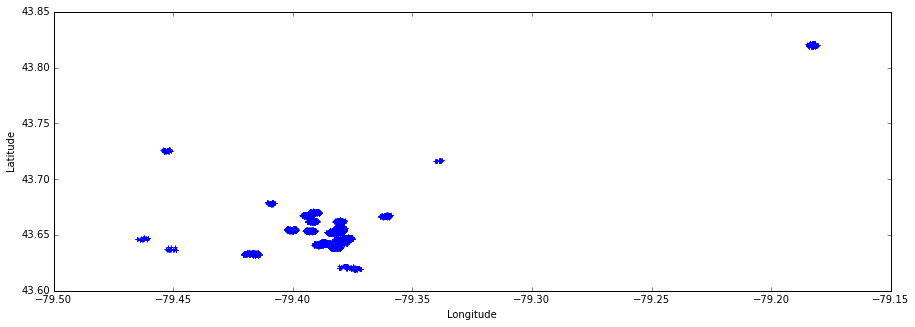

In [23]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [24]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [25]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [32]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

Construct Travelling Sequences

In [41]:
seq_raw = traj[['seqID', 'poiID', 'dateTaken']].copy().groupby(['seqID', 'poiID']).agg([np.min, np.max, np.size])
seq_raw.columns = seq_raw.columns.droplevel()
seq_raw.reset_index(inplace=True)
seq_raw.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_raw['poiDuration(sec)'] = seq_raw['departureTime'] - seq_raw['arrivalTime']
seq_raw.head()

seqID  poiID  arrivalTime  departureTime  #photo  poiDuration(sec)
0      1     30   1346844688     1346844688       1                 0
1      2      6   1142731848     1142732445       4               597
2      3      6   1142916492     1142916492       1                 0
3      4     13   1319327174     1319332848       9              5674
4      5     24   1196128621     1196128878       3               257

In [49]:
seq_len = seq_raw[['seqID', 'poiID']].copy().groupby('seqID').agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_len.head()

seqID  seqLen
0      1       1
1      2       1
2      3       1
3      4       1
4      5       1

In [87]:
seq_stats = seq_raw[['seqID', '#photo', 'poiDuration(sec)']].copy().groupby('seqID').agg(np.sum)
seq_stats.reset_index(inplace=True)
#seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(sec)'}, inplace=True)
seq_stats = pd.merge(seq_len, seq_stats, on='seqID')
seq_stats['poiDuration(sec)'] /= 60
seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(min)'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

seqLen  #photo  totalPoiDuration(min)
seqID                                       
1           1       1               0.000000
2           1       4               9.950000
3           1       1               0.000000
4           1       9              94.566667
5           1       3               4.283333

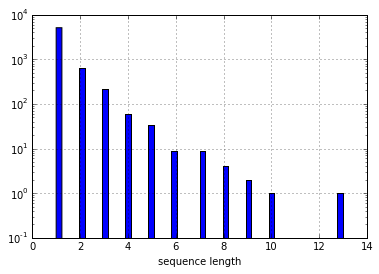

In [88]:
ax = seq_stats['seqLen'].hist(bins=50)
ax.set_xlabel('sequence length')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

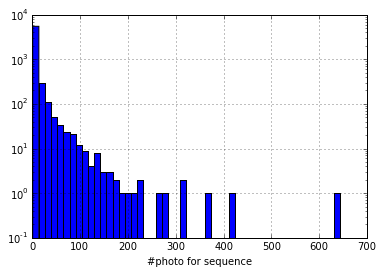

In [89]:
ax = seq_stats['#photo'].hist(bins=50)
ax.set_xlabel('#photo for sequence')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

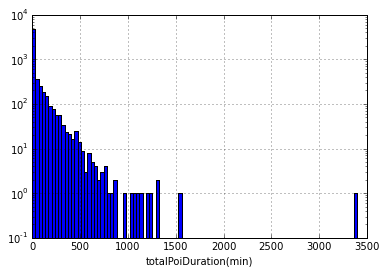

In [90]:
ax = seq_stats['totalPoiDuration(min)'].hist(bins=100)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')
#ax.set_xscale('log')

Sequences with length {3, 4, 5}

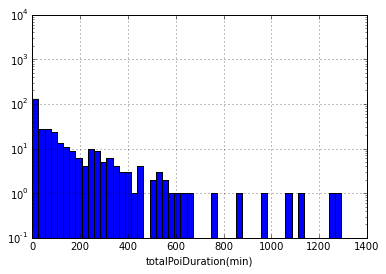

In [91]:
seq_stats = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Do some filtering? (e.g. totalPoiDuration = 0 or too large, seqLen = 1 etc), 8 hours split vs. 6 hours split?

In [92]:
min_duration = 10  # 10 minutes
max_duration = 960 # 16 hours

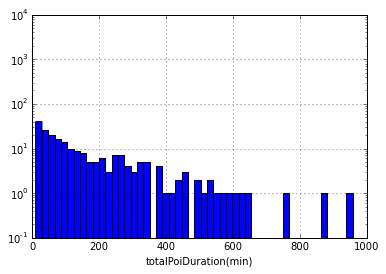

In [93]:
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] > min_duration]
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] < max_duration]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Sequences with the same (start, end), some (start, end) are more popular than others.

what do we need? (start POI category, end POI category) vs. (start POI, end POI)

In [104]:
seq_dict = dict()
for seqid in seq_stats.index:
    assert(seq_stats.loc[seqid, 'seqLen'] >= 2)
    seqi = seq_raw[seq_raw['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    pois = seqi['poiID'].tolist()
    p0 = pois[0]
    pN = pois[-1]
    if (p0, pN, len(pois)) not in seq_dict:
        seq_dict[(p0, pN, len(pois))] = []
    seq_dict[(p0, pN, len(pois))].append(pois)

max: 5 sequences with (start, end, seqLen) (23, 21, 3)
min: 1 sequences with (start, end, seqLen) (3, 22, 3)


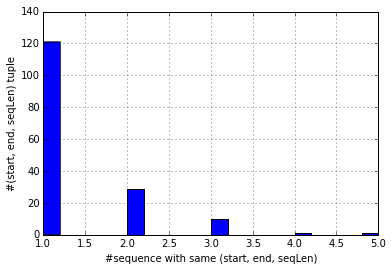

In [105]:
tuples = sorted(seq_dict.keys())
group_size = np.array([len(seq_dict[x]) for x in tuples])
maxidx = group_size.argmax()
minidx = group_size.argmin()
print('max: %d sequences with (start, end, seqLen) %s' % (group_size[maxidx], str(tuples[maxidx])))
print('min: %d sequences with (start, end, seqLen) %s' % (group_size[minidx], str(tuples[minidx])))
ax = pd.Series(group_size).hist(bins=20)
ax.set_xlabel('#sequence with same (start, end, seqLen)')
ax.set_ylabel('#(start, end, seqLen) tuples')

Split sequences into training set and testing set. which kind of split? hold one sequence in each type of (start, end)?